In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Dataset/lyrics_cleaned_final.csv')
print(df.head())

   Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0           artist  \
0             0             0           0            Usher   
1             1             1           1         Da'Ville   
2             2             2           2          Rihanna   
3             3             3           3       J. Holiday   
4             4             4           4  Morgan Heritage   

                 name  emotion  index  \
0  There Goes My Baby  relaxed      0   
1          On My Mind  relaxed      1   
2       Rockstar 101   relaxed      2   
3                 Bed  relaxed      3   
4   Don't Haffi Dread    angry      4   

                                      cleaned_lyrics  
0  Yeah, right Usher, baby Okay Yeah man Right (T...  
1  Ahhhhhhhh You're om my mind Yea Verse1 I'm thi...  
2  I told ya, I told ya I told ya baby, baby Uh, ...  
3   J. Holiday Oo-oh, oo-oh (Ay-ay-ay, Ay, Ay-ay-...  
4  Yeah, yeah, yeah - ragga so ragga You don't ha...  


In [ ]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0.2', 'index', 'Unnamed: 0'])  # Drop unwanted columns

import nltk
import string
import inflect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Initializations
p = inflect.engine()
lemmatizer = WordNetLemmatizer()

# 1. Lowercase
def text_lowercase(text):
    return text.lower()

# 2. Convert numbers to words
def convert_number(text):
    temp_str = text.split()
    new_string = []
    for word in temp_str:
        if word.isdigit():
            temp = p.number_to_words(word)
            new_string.append(temp)
        else:
            new_string.append(word)
    return ' '.join(new_string)

# 3. Remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# 4. Remove whitespaces
def remove_whitespace(text):
    return " ".join(text.split())

# 5. Remove stopwords (but keep 'no' and 'not')
stop_words = set(stopwords.words('english'))
stop_words.discard('no')
stop_words.discard('not')

def remove_stopwords(text):
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

# 6. Lemmatization
def lemmatize_word(text):
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in tokens])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Function to preprocess lyrics
def preprocess_lyrics(df, column_name='cleaned_lyrics'):

    # Apply preprocessing steps
    df[column_name] = df[column_name].apply(text_lowercase)
    df[column_name] = df[column_name].apply(convert_number)
    df[column_name] = df[column_name].apply(remove_punctuation)
    df[column_name] = df[column_name].apply(remove_whitespace)
    df[column_name] = df[column_name].apply(remove_stopwords)
    df[column_name] = df[column_name].apply(lemmatize_word)

    return df

# Usage example:
# Assuming df is your dataframe
df = preprocess_lyrics(df, column_name='cleaned_lyrics')
df.head()


,artist,name,emotion,cleaned_lyrics
0,Usher,There Goes My Baby,relaxed,yeah right usher baby okay yeah man right turn...
1,Da'Ville,On My Mind,relaxed,ahhhhhhhh youre om mind yea verse1 im thinkin ...
2,Rihanna,Rockstar 101,relaxed,tell ya tell ya tell ya baby baby uh uh tell y...
3,J. Holiday,Bed,relaxed,j holiday oooh oooh ayayay ay ayayay ay ayayay...
4,Morgan Heritage,Don't Haffi Dread,angry,yeah yeah yeah ragga ragga dont ha fi dread ra...


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [ ]:
# Tokenizer parameters
vocab_size = 10000  # Increase vocab size
max_length = 100  # Or adapt to your dataset

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_lyrics'])

# Convert text to padded sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_lyrics'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Encode emotion labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['emotion'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [ ]:
# Model architecture with increased LSTM units and embedding dimensions
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))  # Increased embedding dimension
model.add(LSTM(128, return_sequences=False))  # Increased LSTM units
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(labels)), activation='softmax'))  # Output layer for multi-class

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,420,100 (5.42 MB)

 Trainable params: 1,420,100 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Class weight calculation to handle class imbalance
class_weights = dict(zip(np.unique(y_train), np.bincount(y_train) / len(y_train)))

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - accuracy: 0.3151 - loss: 0.3405 - val_accuracy: 0.4478 - val_loss: 1.0761
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 394ms/step - accuracy: 0.4866 - loss: 0.2797 - val_accuracy: 0.5674 - val_loss: 0.9365
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step - accuracy: 0.6349 - loss: 0.2150 - val_accuracy: 0.6438 - val_loss: 0.8103
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.7320 - loss: 0.1764 - val_accuracy: 0.6896 - val_loss: 0.8513
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - accuracy: 0.7674 - loss: 0.1698 - val_accuracy: 0.6921 - val_loss: 0.7430
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 419ms/step - accuracy: 0.8337 - loss: 0.1153 - val_accuracy: 0.7557 - val_loss: 0.7667
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.7929 - loss: 0.1436 - val_accuracy: 0.8041 - val_loss: 0.5564
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.8838 - loss: 0.1037 - val_accu

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step

 Classification report:
              precision    recall  f1-score   support

       angry       0.80      0.96      0.87       107
       happy       0.85      0.91      0.88        85
     relaxed       0.95      0.86      0.90       105
         sad       0.95      0.77      0.85        96

    accuracy                           0.88       393
   macro avg       0.89      0.87      0.87       393
weighted avg       0.89      0.88      0.88       393



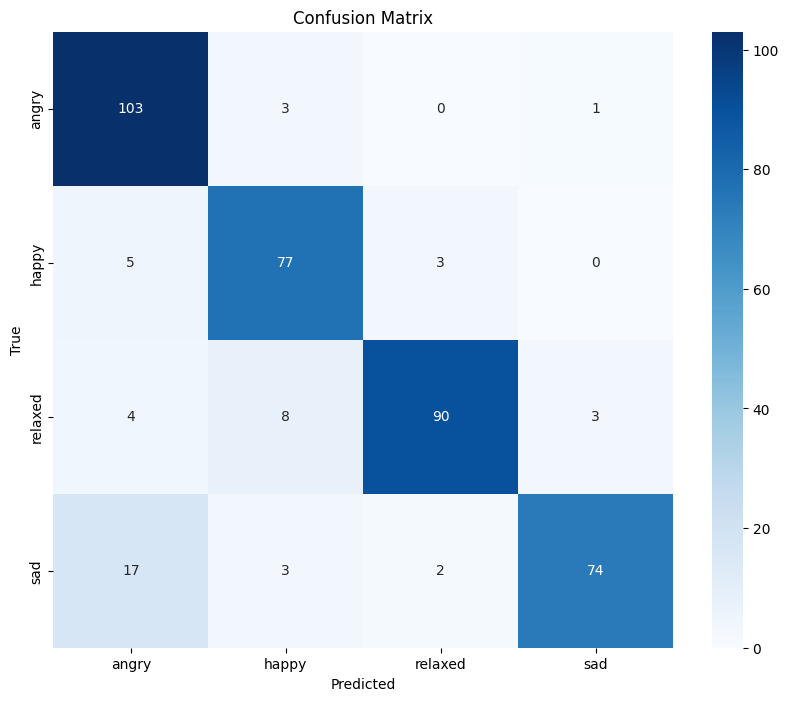

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
target_names = label_encoder.classes_
print("\n Classification report:")
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

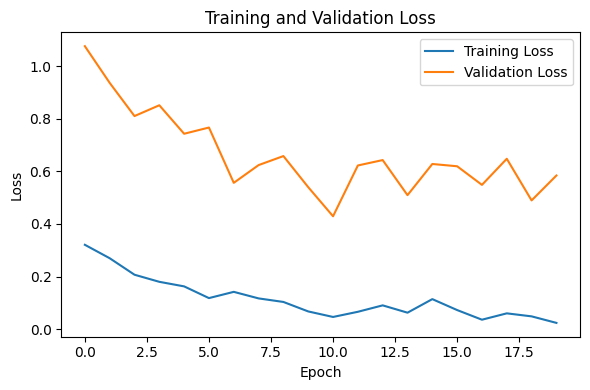

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Number of samples to test
n_samples = 5

# Select the first n samples
sample_lyrics = df['cleaned_lyrics'].iloc[:n_samples].values
true_labels = df['emotion'].iloc[:n_samples].values

# Tokenize and pad
sample_sequences = tokenizer.texts_to_sequences(sample_lyrics)
sample_padded = pad_sequences(sample_sequences, maxlen=100, padding='post', truncating='post')

# Predict
predictions = model.predict(sample_padded)
predicted_labels = np.argmax(predictions, axis=1)
predicted_emotions = label_encoder.inverse_transform(predicted_labels)

# Display results
for i in range(n_samples):
    print(f"Sample {i+1}:")
    print(f"Lyric Preview: {sample_lyrics[i][:200]}...")
    print(f"Actual Emotion: {true_labels[i]}")
    print(f"Predicted Emotion: {predicted_emotions[i]}")
    print("-" * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Sample 1:
Lyric Preview: yeah right usher baby okay yeah man right turn light go baby ooh girl look dont know good feel call girl go baby yeah love everything ooh girl look bet aint know check put heel swear body perfect baby...
Actual Emotion: relaxed
Predicted Emotion: relaxed
----------------------------------------------------------------------------------------------------
Sample 2:
Lyric Preview: ahhhhhhhh youre om mind yea verse1 im thinkin girl miss ou ou baby ever since day go away yea cant live without chorus youre always mind mind youre always mind youre always mind girl youre mind verse2...
Actual Emotion: relaxed
Predicted Emotion: relaxed
----------------------------------------------------------------------------------------------------
Sample 3:
Lyric Preview: tell ya tell ya tell ya baby baby uh uh tell ya baby uh oh uh uh tell ya baby uh uh tell ya baby uh oh uh uh tell ya baby uh oh uh uh tell ya baby uh oh uh uh tell ya get club